In [17]:
import numpy as np
import matplotlib.pyplot as plt
import jax 
import jax.numpy as jnp 

At epoch = 0, loss = 0.036181
At epoch = 200, loss = 0.011888
At epoch = 400, loss = 0.009780
At epoch = 600, loss = 0.008924
At epoch = 800, loss = 0.008573
At epoch = 1000, loss = 0.008428
After training, the predicted theta is a = 1.509, β = 0.319, ω = 9.885, δ = 0.297


'Note that the loss asymptotes to ~ 8e-3 (good fit) but does not reach 0 due to noise in the data.'

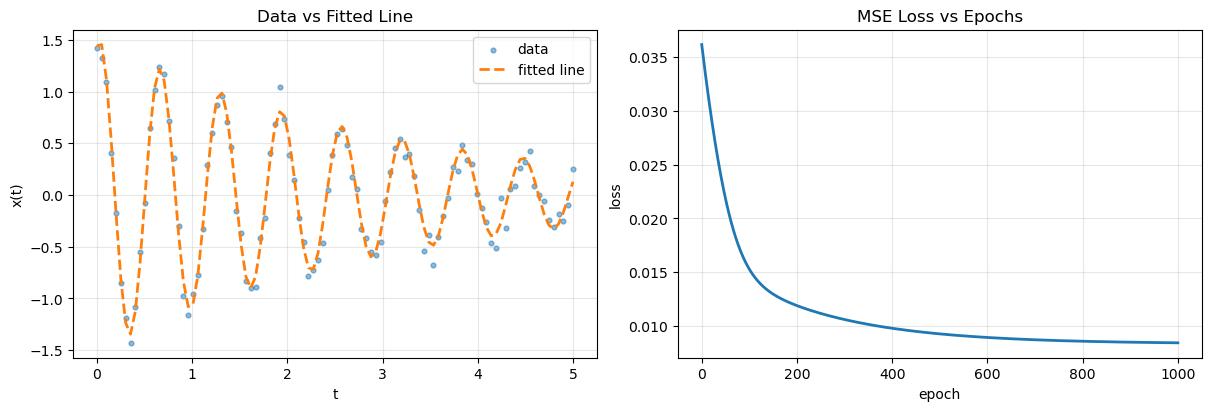

In [ ]:
# 1.1 (single-layer NN for parameter inference using SGD in JAX)
# - N: number of noisy samples from the damped harmonic oscillator
# - times  ∈ R^{N}  # scalar input per sample (d_in = 1)
# - x_data ∈ R^{N}  # scalar target per sample (d_out = 1)
# shapes are (N,) (1D arrays) not (N,1)
num_samples = 100
time_end = 5.0
times  = jnp.linspace(0.0, time_end, num_samples)     
x_data = jnp.array([ 1.42136407e+00,  1.32538052e+00,  1.08997205e+00,  4.01375320e-01,
       -1.78495795e-01, -8.50696683e-01, -1.18615104e+00, -1.42918430e+00,
       -1.08653056e+00, -5.51030603e-01, -7.50736710e-02,  6.47062767e-01,
        1.01484947e+00,  1.23909135e+00,  1.16973363e+00,  7.14521669e-01,
        3.55287429e-01, -2.95169206e-01, -9.74425168e-01, -1.16492314e+00,
       -9.52631079e-01, -7.77656938e-01, -3.28057458e-01,  2.92744065e-01,
        6.01953380e-01,  8.65371671e-01,  9.54240091e-01,  7.08483475e-01,
        4.68455172e-01, -1.56245101e-01, -3.70602686e-01, -8.30733462e-01,
       -8.95167164e-01, -8.91137955e-01, -4.18014142e-01, -2.22376053e-01,
        4.10047775e-01,  6.88406843e-01,  1.04061990e+00,  7.30025281e-01,
        3.90618018e-01,  1.43181366e-01, -2.20778546e-01, -4.53298514e-01,
       -7.87562022e-01, -7.21285197e-01, -6.27664217e-01, -4.65873073e-01,
        4.76786963e-02,  3.89328316e-01,  5.92877625e-01,  6.37519856e-01,
        4.83785342e-01,  1.71821980e-01,  5.43082539e-02, -3.29509591e-01,
       -4.12974420e-01, -5.53475010e-01, -5.83206553e-01, -4.58252882e-01,
       -5.48980467e-02,  2.26195369e-01,  4.52451610e-01,  5.38430311e-01,
        3.67845822e-01,  3.97176254e-01,  1.84432283e-01, -1.49708735e-01,
       -5.37683940e-01, -3.88877197e-01, -6.79843289e-01, -4.05592818e-01,
       -2.06048677e-01, -3.04612159e-02,  2.73534969e-01,  2.33194682e-01,
        4.87619039e-01,  3.34767833e-01,  3.00019677e-01,  9.12268252e-03,
       -1.21252257e-01, -2.57336778e-01, -4.68953016e-01, -5.12673830e-01,
       -2.89839003e-02, -3.22855227e-01,  5.86021068e-02,  8.32512072e-02,
        2.60554538e-01,  3.23171785e-01,  4.29277758e-01,  8.75180664e-02,
       -1.17562189e-03, -5.57391100e-02, -2.43060644e-01, -3.07899430e-01,
       -1.78936431e-01, -2.53676100e-01, -9.54204646e-02,  2.55114941e-01], dtype=jnp.float32)

# single-layer parametric fit: f(t; θ) = a * exp(-β t) * cos(ω t - δ) = x̂
# learnable parameters: θ = (a, β, ω, δ) ∈ R^{4}  → stored as a 1D array of shape (4,)
# use all N samples each step (batch size B = N); with t, x, x̂ ∈ R^{N} shapes are (N,) (1D arrays) not (N,1)
def f(theta, t):
    a, beta, omega, delta = theta
    return a * jnp.exp(-beta*t) * jnp.cos(omega*t - delta)

def initial_parameters():
    return jnp.array([1.5, 0.5, 10.0, 0.5]) # reasonable initial guess for θ = (a, β, ω, δ)

# MSE loss over the full batch
def mse(theta, t, x):
    return jnp.mean((f(theta, t) - x)**2)

# One SGD step over the full batch 
@jax.jit
def sgd_step(theta, t, x, lr):
    loss, grads = jax.value_and_grad(mse)(theta, t, x)
    theta = theta - lr * grads
    return theta, loss

theta = initial_parameters()
lr = 1e-2
losses = []
num_epochs = 1000
epochs = jnp.arange(0, num_epochs + 1) # epochs = [0, 1, 2, ..., num_epochs]

for epoch in epochs:
    theta, loss = sgd_step(theta, times, x_data, lr)
    if epoch % (num_epochs // 5) == 0:
        print(f"At epoch = {epoch}, loss = {loss:.6f}")
    losses.append(loss)

fig, axs = plt.subplots(1,2, figsize = (12,4), constrained_layout=True)
x_fit = f(theta, times)

axs[0].scatter(times, x_data, s=12, alpha=0.5, label="data")
axs[0].set_title("Data vs Fitted Line")
axs[0].plot(times, x_fit, '--', color = 'C1', lw=2, label="fitted line")
axs[0].set_xlabel("t")
axs[0].set_ylabel("x(t)")
axs[0].legend()
axs[0].grid(alpha=0.3)

axs[1].plot(epochs, losses, lw=2) 
axs[1].set_title("MSE Loss vs Epochs")
axs[1].set_xlabel("epoch")
axs[1].set_ylabel("loss")
axs[1].grid(alpha=0.3)

print(f"After training, the predicted theta is a = {theta[0]:.3f}, β = {theta[1]:.3f}, ω = {theta[2]:.3f}, δ = {theta[3]:.3f}")
'Note that the loss asymptotes to ~ 8e-3 (good fit) but does not reach 0 due to noise in the data.'

In [ ]:
# 1.2 (single-layer NN for parameter inference using ADAMW in PyTorch)